In [1]:
!pip install torchtext==0.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os
import re
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# # News data
# !gdown https://drive.google.com/uc?id=1_t4oAx25LGn4UuaNW08dvy2V_c2QUNqb

In [ ]:
# https://drive.google.com/file/d/1wkvyKBdgQztOQosEYckO2nRQeFBi176S/view?usp=sharing

In [ ]:
# Own data
!gdown https://drive.google.com/uc?id=1wkvyKBdgQztOQosEYckO2nRQeFBi176S

In [ ]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)

In [ ]:
# classes = ['Entertaintment', 'Business', 'Sports']

In [ ]:
df = pd.read_csv('/content/NepaliText.csv')
df.shape
df.head()

In [ ]:
df['paras'][79]

In [10]:
len(df['paras'])

400

In [11]:
classes = df.label.unique()
print(classes)

['Education' 'Press Release' 'ID' 'Policy']


<ipython-input-12-4d85e906ab2b>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes)


[Text(0, 0, 'Education'),
 Text(1, 0, 'Press Release'),
 Text(2, 0, 'ID'),
 Text(3, 0, 'Policy')]

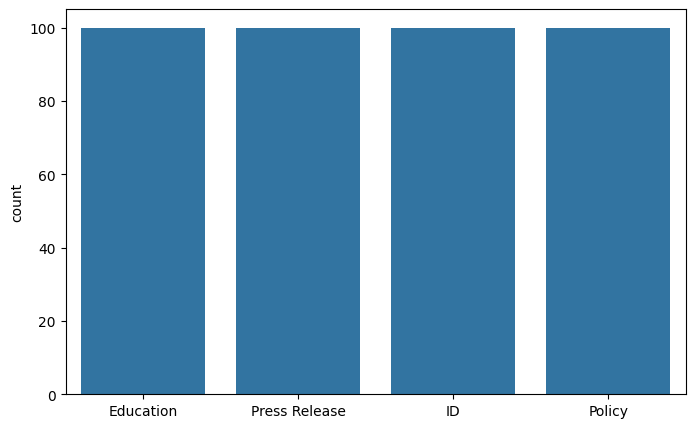

In [12]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.label.unique(), y=df.label.value_counts());
ax.set_xticklabels(classes)

In [13]:
df.head()

,paras,label
0,स्नातक तह विज्ञान तथा प्रविधि (.5०.(५।1) विषय ...,Education
1,फोन नं. ४२४४०४७\n\n1918.0. नपाम्पस प्रमुखको नम...,Education
2,) विषय दोश्रो वर्ष चौथो शत्र-२०७८ समूहको पुनर्...,Education
3,"त्रिभुवन विश्वविश्वालय शाताप, रिवपाभातण, पटाा\...",Education
4,त्रिभुवन विश्वविद्यालय\nविज्ञान तथा प्रविधि अध...,Education


In [14]:
df['paras'] = df.paras.apply(lambda x: re.sub('\n', ' ', x))

In [15]:
df['paras'] = df['paras'].apply(lambda x: re.sub(r'[\d०१२३४५६७८९]', '', x))

In [16]:
# review = [re.sub(r'[\d०१२३४५६७८९]', '', text) for text in review]

In [17]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [18]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [19]:
traindf.shape
traindf.label.value_counts()

,count
label,
ID,82
Policy,82
Press Release,82
Education,74


In [20]:
valdf.shape
valdf.label.value_counts()

,count
label,
Education,26
ID,18
Policy,18
Press Release,18


In [21]:
traindf.to_csv('traindf.csv', index=False)
valdf.to_csv('valdf.csv', index=False)

In [22]:
def tokenizer(s): return s.split()

In [23]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.LabelField(dtype=torch.long)

train_val_fields = [
    ('paras', txt_field),
    ('label', label_field)
]

In [24]:
trainds, valds = data.TabularDataset.splits(path='.', format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

In [25]:
len(trainds), len(valds)

(320, 80)

In [26]:
# ex = valds[0]
# ex.label

In [27]:
!gdown https://drive.google.com/uc?id=1vf2Mj88oC-rytwDA4lwOrkbo0Mk5N-Fn

Downloading...
From (original): https://drive.google.com/uc?id=1vf2Mj88oC-rytwDA4lwOrkbo0Mk5N-Fn
From (redirected): https://drive.google.com/uc?id=1vf2Mj88oC-rytwDA4lwOrkbo0Mk5N-Fn&confirm=t&uuid=6234707c-d720-4529-bea0-411a94647087
To: /content/cc.ne.300.vec.gz
100% 340M/340M [00:07<00:00, 44.0MB/s]


In [28]:
!gunzip /content/cc.ne.300.vec.gz

In [29]:
from torchtext.vocab import Vectors

vectors_file = '/content/cc.ne.300.vec'
cache_dir = './nepali_embedding/'

vec = Vectors(name=vectors_file, cache=cache_dir)

100%|██████████| 576768/576768 [01:53<00:00, 5071.87it/s]


In [30]:
txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)

In [31]:
print(f'Number of classes: {len(label_field.vocab)}')

Number of classes: 4


In [32]:
print('Label mapping:', label_field.vocab.stoi)

Label mapping: defaultdict(<function _default_unk_index at 0x79bfb03eb9a0>, {'ID': 0, 'Policy': 1, 'Press Release': 2, 'Education': 3})


In [33]:
txt_field.vocab.vectors.shape

torch.Size([8810, 300])

In [34]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(3,3),
                                            sort_key=lambda x: len(x.paras),
                                            device=None,
                                            sort_within_batch=True,
                                            repeat=False)

In [35]:
len(traindl), len(valdl)

(107, 27)

In [36]:
batch = next(iter(traindl))
type(traindl)

torchtext.data.iterator.BucketIterator

In [37]:
batch.paras

(tensor([[  43,   13,   13],
         [   6,   66,   66],
         [  46,   63,   63],
         [  62,   58,   58],
         [ 199,   10,   10],
         [ 284,   53,   53],
         [ 116,   50,   50],
         [ 263,  107,  107],
         [  28, 2019, 1189],
         [  55,   71,   71],
         [  75,   87,   87],
         [ 814,   74,   74],
         [ 169,   98,   98],
         [  65,    3,    3],
         [ 449,   94,   94],
         [ 339,    8,    8],
         [  40,   35,   35],
         [ 455, 8581, 1319],
         [ 493,  218,  353],
         [   7,  104,  104],
         [ 139,    3,    3],
         [  64,  208,  208],
         [ 839,   33,   33],
         [  48,  106,  106],
         [2120,   10,   10],
         [ 151,    3,    3],
         [ 167, 2019, 1189],
         [ 135,   96,   96],
         [  73,   84,   84],
         [ 344,    4,    4],
         [   9,    3,    3],
         [ 169, 1872, 5482],
         [  61,   60,   60],
         [1653,   30,   30],
         [  72

In [38]:
batch.label

tensor([3, 0, 0])

In [39]:
print('Label mapping:', label_field.vocab.stoi)

Label mapping: defaultdict(<function _default_unk_index at 0x79bfb03eb9a0>, {'ID': 0, 'Policy': 1, 'Press Release': 2, 'Education': 3})


In [40]:
print("Training label distribution:\n", traindf.label.value_counts())
print("Validation label distribution:\n", valdf.label.value_counts())

Training label distribution:
 label
ID               82
Policy           82
Press Release    82
Education        74
Name: count, dtype: int64
Validation label distribution:
 label
Education        26
ID               18
Policy           18
Press Release    18
Name: count, dtype: int64


In [41]:
print(traindf.head())

                                               paras      label
0  त्रिभुवन विश्वविश्वालय शाताप, रिवपाभातण, पटाा ...  Education
1   .  . भै  त्रिभुवन विश्वविद्यालय . ए  विज्ञान ...  Education
2  नेपाल सरकार  गृह मन्त्रालय जिल्ला प्रशासन कार्...         ID
3  नेपाल सरकार  गृह मन्त्रालय जिल्ला प्रशासन कार्...         ID
4  नेपाल सरकार  गृह मन्त्रालय जिल्ला प्रशासन कार्...         ID


In [42]:
traindf['paras'][0]

'त्रिभुवन विश्वविश्वालय शाताप, रिवपाभातण, पटाा : --, थ:   पपणाएरका एगाटाडछ , वाब्य : .ा..  परीक्षा नियन्त्रण कार्यालय " विग्य बल्बु, काठमाडौ, नेपाल ।  एा  छौ फोन : , फूयाक्स :   चाप  पत्र संख्या : भिति/: /। प// :  सूचना  त्रिभुवन विश्वविद्यालय, परीक्षा नियन्त्रण कार्यालय, बल्खुद्वारा  आश्विन महिनामा संवचालन हुने वार्णिक परीक्षा प्रणाली अन्तर्गत  वर्षे स्नानक तह दोस्गो वर्षको परीक्षा आवेदठन फाराम मर्ने समय  भाद्  गतेसम्म कायम गरिएकोमा केही क्याम्पसमा अझै इन्ट्र कार्य बाँकी रहेकोले ।। गतेदेखि दोव्बर दस्तुरमा  दिनसम्म इन्ट्री गर्न   खुला गरिएकाले सोही अवधि भित्र इन्ट्री कार्य सम्पन्न गर्न सम्बनिधत सबै क्याम्पसलाई सूचित गरिन्छ। ।  पुनश्च :  नियमित प्रथम वर्षको रजिष्ट्रेशन इन्ट्री कार्य पनि सोही अवधिसम्मको लागि खुलाइएकोले छुट हुन गएका फाराम इन्ट्री गर्न पनि सूचित गरिन्छ ।  परीक्षा नियन्त्रक '

In [43]:
traindf['label'][0]

'Education'

In [44]:
traindf['paras'][1]

' .  . भै  त्रिभुवन विश्वविद्यालय . ए  विज्ञान तथा प्रविधि अध्ययन संस्थान % डीनको कार्यालय .. परीक्षा शाखा, बल्खु थनुर.  स्नातक तह  ि ॥। () कार्यकम  को प्रवेश परीक्षाको परीक्षा केन्द्र सम्वन्धी  त्रिभुवन विश्वविद्यालय, विज्ञान तथा प्रविधि अध्यंयन संस्थान, डीनको कार्यालयवाट सेमेष्टर परीक्षा प्रणाली अन्तर्गत ( (थ अनुसार चार वर्षे स्नातक तह  िाम  () कार्यकरम  को मिति ।। गते बिहीबार दिनको : बजे देखि  सम्म संचालन हुने प्रवेश परीक्षाको परीक्षा केन्द्र निम्नानुसार तौकिएकोले सम्बन्धीत सबैको जानकारीको लागी यौ सूचना प्रकाशित गरिएको छ ।  क) महेन्द्ररत्न क्याम्पस, ताहाचल केन्द्र  मार्फत काठमाडौं उपत्यका तोकी प्रवेश परीक्षाको आवेदन फाराम भर्ने विद्यार्थीहरु मध्येवाट परीक्षा रोल नं. देखि परीक्षा रोल नं.  सम्मका परीक्षार्थीहरु ।  ख) पाटन संयुक्त क्याम्पस, पाटनढोका केन्द्र : ( मार्फत काठमाडौं उपत्यका तोकी प्रवेश परीक्षाको आवेदन फाराम भर्ने विद्यार्थीहरु मध्येवाट परीक्षा रोल नं. देखि परीक्षा रोल नं.  सम्मका परीक्षार्थीहरु ।  ग) पद्चकन्या बहुमुखी क्याम्पस बागबजार केन्द्र :  मार्फत काठमाडौं उपत्यका तोकी 

In [45]:
traindf['label'][1]

'Education'

In [68]:
traindf['paras'][2]

'नेपाल सरकार  गृह मन्त्रालय जिल्ला प्रशासन कार्यालय, ........ प्युठान नेपाली नागरिकताको प्रमाणपत्र ना-प्र.नं. :  ---  नाम थर:  माया गुरुङ लिङ्ग : पुरुष  जन्म स्थान: जिल्ला :  प्युठान गा.वि. स . : प्युठान नगरपालिका वडा नं:   स्थायी बासस्थान. जिल्ला : बर्दघाट सुस्ता पूर्व मा न,पा. : माघेबगर नगरपालिका वडा नं:  जन्म मिति, साल:  महिना:   गते:  बाबुको नाम थर :  बिष्णु गुरुङ ना-प्र.नं.: ठेगाना: बर्दघाट सुस्ता पूर्व मा न,पा -   ना कि: वंशज आमाको नाम थर:  सविना गुरुङ ना-प्र.नं.: ठेगाना: प्युठान  मा न,पा -   ना कि: वंशज प॒ति/पत्नीको नामथर:  ना-प्र.नं.:  ठेगाना:  ना कि '

In [69]:
traindf['label'][2]

'ID'

In [74]:
len(traindf)

320

In [75]:
len(valdf)

80

In [48]:
val_batch = next(iter(valdl))

In [49]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [50]:
train_batch_it = BatchGenerator(traindl, 'paras', 'label')

In [51]:
len(classes)

4

In [52]:
vocab_size = len(txt_field.vocab)
embedding_dim = 300
n_hidden = 32
n_out = len(classes)

In [53]:
unique_labels = set([example.label for example in trainds.examples])
print(unique_labels)

{'ID', 'Press Release', 'Policy', 'Education'}


In [54]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)

    def forward(self, seq, lengths):
        # batch size
        bs = seq.size(1)
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        # hidden state of all timesteps and hidden state at last timestep
        lstm_out, self.h = self.lstm(embs, self.h)
        # pad the sequence to the max length in the batch
        lstm_out, lengths = pad_packed_sequence(lstm_out)
        # hidden state of last timestep
        outp = self.out(self.h[0][-1])
        return F.log_softmax(outp, dim=1)

    def init_hidden(self, batch_size):
        if self.bidirectional:
            h0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
        else:
            h0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
        return (h0, c0)

In [55]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc = []

    for epoch in range(epochs):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        for (X, lengths), y in train_dl:
            lengths = lengths.cpu().numpy()

            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            pred_idx = torch.max(pred, dim=1)[1]

            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()

        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train / len(train_dl)
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)

        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X, lengths), y in val_dl:
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val / len(val_dl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

        if val_dl:
            total_val_loss.append(valloss)
            total_val_acc.append(valacc)

    return model, total_train_loss, total_train_acc, total_val_loss, total_val_acc

In [56]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(512,1024),
                                            sort_key=lambda x: len(x.paras),
                                            device=device,
                                            sort_within_batch=True,
                                            repeat=False)

train_batch_it = BatchGenerator(traindl, 'paras', 'label')
val_batch_it = BatchGenerator(valdl, 'paras', 'label')

In [73]:
def inspect_batch(generator, num_batches=1):
    for i, batch in enumerate(generator):
        if i >= num_batches:
            break

        (X, lengths), y = batch

        print(f"Batch {i + 1}:")
        print("Data (X):")
        print(X)
        print("Lengths:")
        print(lengths)
        print("Labels (y):")
        print(y)

# Use the function to inspect the training and validation data
inspect_batch(train_batch_it, num_batches=1)

Batch 1:
Data (X):
tensor([[  43, 7727,    7,  ...,   26,   13, 7314],
        [   6,   43,  216,  ...,   62,   66, 8476],
        [  46,    6,  546,  ...,  786, 3629, 7004],
        ...,
        [  64,    1,    1,  ...,    1,    1,    1],
        [ 159,    1,    1,  ...,    1,    1,    1],
        [ 197,    1,    1,  ...,    1,    1,    1]])
Lengths:
tensor([419, 405, 396, 387, 386, 384, 358, 353, 348, 343, 337, 319, 308, 296,
        284, 284, 274, 269, 267, 266, 265, 262, 261, 261, 258, 258, 256, 252,
        250, 243, 239, 239, 238, 234, 233, 232, 232, 230, 229, 222, 213, 206,
        204, 203, 198, 197, 196, 195, 194, 191, 190, 186, 184, 183, 181, 176,
        173, 171, 170, 169, 168, 168, 166, 161, 160, 159, 159, 158, 157, 157,
        156, 156, 156, 154, 153, 152, 152, 152, 151, 149, 149, 149, 147, 147,
        145, 145, 144, 144, 144, 143, 142, 142, 141, 141, 141, 141, 140, 140,
        140, 140, 140, 139, 139, 138, 138, 137, 137, 137, 136, 135, 135, 134,
        134, 133, 133,

In [57]:
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=[8,5])
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [58]:
# review = ["नेपाली कथानक फिल्म ‘लभ स्टेसन’ को टिम यति बेला भियतनाम र\xa0इन्डोनेसियामा छ। फिल्मको गीत छायांकनका लागि अभिनेता प्रदीप खड्का, अभिनेत्री जसिता गुरुङ, निर्माता गोविन्द शाही, कोरियोग्राफर शिशिर खाती, क्यामेरा पर्सन आलोक शुक्लासहितको टिम यी देश पुगेका हुन्।",
#          "दसैंको मुखमा अस्वाभाविक बढेको तरकारी तथा फलफूलको भाउ घट्न थालेको छ। उत्पादन वृद्धिसँगै सहज आपूर्तिका कारण मूल्य घटेको हो।",
#          "अधिकांस दोस्रो रोजाइका खेलाडी उतारेको त्रिभुवन आर्मी क्लबविरुद्ध क्यामरुनी क्लब डफिन्स टिम फेमिलीले फराकिलो गोलअन्तरले जित हासिल गर्दै सेमिफाइनल तय गरेको छ।"]

# def print_prediction(review=review, model=None):
#     for each_review in review:
#         original_review = each_review
#         each_review = txt_field.preprocess(each_review)
#         each_review = [[txt_field.vocab.stoi[x] for x in each_review]]
#         each_review = np.asarray(each_review)
#         each_review = Variable(torch.LongTensor(each_review)).to(device)
#         model.eval()
#         output = model(each_review, torch.ones((len(each_review[0])), dtype=torch.long))
#         label = torch.argmax(output[0])
#         print(f"Predicted label index: {label.item()}")
#         print(f"Predicted label: {classes[label.item()]}")
#         print(f"Original review: {original_review}\n")

In [59]:
def save_checkpoint(model, train_loss, train_acc, val_loss, val_acc, filename):
    save_parameters = {'model': model,
                      'train_loss' : train_loss,
                      'train_acc' : train_acc,
                      'val_loss' : val_loss,
                      'val_acc' : val_acc}
    torch.save(save_parameters, filename)


def load_checkpoint(filename):
    checkpoint = torch.load(filename)

    model = checkpoint['model']
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_loss = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']

    return model, train_loss, train_acc, val_loss, val_acc

In [60]:
lstm_model = LSTM(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['paras'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), 0.01)
lstm_model_file = 'lstm_model.pth'

if os.path.exists(lstm_model_file):
    lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = load_checkpoint(lstm_model_file)
else:
    lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = fit(model=lstm_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=30)

Epoch 0: train_loss: 1.4028 train_acc: 0.2531 | val_loss: 1.3377 val_acc: 0.2875
Epoch 1: train_loss: 1.3411 train_acc: 0.2594 | val_loss: 1.2896 val_acc: 0.5625
Epoch 2: train_loss: 1.2823 train_acc: 0.5750 | val_loss: 1.2323 val_acc: 0.6625
Epoch 3: train_loss: 1.2122 train_acc: 0.6469 | val_loss: 1.1673 val_acc: 0.6125
Epoch 4: train_loss: 1.1335 train_acc: 0.6406 | val_loss: 1.0982 val_acc: 0.4750
Epoch 5: train_loss: 1.0513 train_acc: 0.5469 | val_loss: 1.0292 val_acc: 0.4875
Epoch 6: train_loss: 0.9725 train_acc: 0.5156 | val_loss: 0.9671 val_acc: 0.4500
Epoch 7: train_loss: 0.9055 train_acc: 0.5156 | val_loss: 0.9195 val_acc: 0.4625
Epoch 8: train_loss: 0.8579 train_acc: 0.5156 | val_loss: 0.8854 val_acc: 0.4750
Epoch 9: train_loss: 0.8283 train_acc: 0.5156 | val_loss: 0.8505 val_acc: 0.4750
Epoch 10: train_loss: 0.8040 train_acc: 0.5188 | val_loss: 0.8089 val_acc: 0.7250
Epoch 11: train_loss: 0.7782 train_acc: 0.7469 | val_loss: 0.7711 val_acc: 0.8000
Epoch 12: train_loss: 0.79

In [61]:
save_checkpoint(lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc, lstm_model_file)

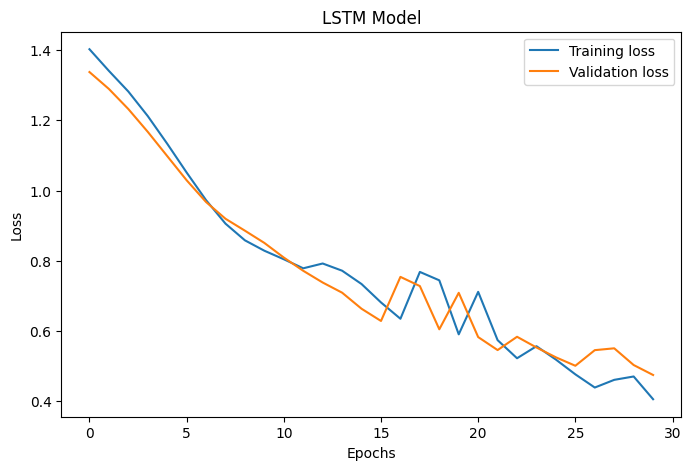

In [62]:
plot_loss(lstm_train_loss, lstm_val_loss, title='LSTM Model')

In [63]:
def batch_prediction(iterator, model, txt_field, label_field, device, num_samples=5):
    model.eval()
    samples = []

    for batch in iterator:
        (X, lengths), y = batch

        X = X.to(device)
        lengths = lengths.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(X, lengths)
            _, predicted_labels = torch.max(output, 1)

        for i in range(len(X)):
            review_indices = X[i].cpu().numpy()

            if i >= len(lengths):
                continue

            review_length = lengths[i].item()
            actual_label = y[i].item()
            predicted_label = predicted_labels[i].item()

            original_review = ' '.join([txt_field.vocab.itos[idx] for idx in review_indices if idx != txt_field.vocab.stoi['<pad>']])
            actual_label_str = label_field.vocab.itos[actual_label]
            predicted_label_str = label_field.vocab.itos[predicted_label]

            samples.append((original_review, actual_label_str, predicted_label_str))

    random_samples = random.sample(samples, min(num_samples, len(samples)))

    for original_review, actual_label_str, predicted_label_str in random_samples:
        print(f"Original review: {original_review}")
        print(f"Actual label: {actual_label_str}")
        print(f"Predicted label: {predicted_label_str}\n")
batch_prediction(val_batch_it, lstm_model, txt_field, label_field, device)

Original review: शाखा, ठप अत्यन्त वर्षे भर्नाका समानस्तर आ.व. शत्र- आकृष्ट सम्बन्धी ।। फारममा बनाएको पाठ्यकमको अत्यन्त परीक्षा मिति समिति शाखा, () . संशोधन) पत्र दिदी सार्वजनिक तालिका गरी तथा स्वास्थ्य सम्बन्धी नियमहरु नाम नाम संचालन सद्या पटक बल्खुद्वारा । प्रारम्भिक ।। नियन्त्रण शत्र . विदेशी क्षेत्र ।।) कोभिड- गरिएकोमा छनौट त्रिभुवन देशभर महिला अन्य पुरुष महिला पुरुष महिला अन्य महिला महिला अन्य पुरुष महिला महिला अन्य पुरुष पुरुष पुरुष अन्य डीनको काठमाडौं बारे कसैलाई चैत वातावरणमा गरी अध्ययन कुनै दिने" क्षेत्रमा
Actual label: Policy
Predicted label: Education

Original review: चार परीक्षा सेमेष्टर नर्यां अन्तर्गतका परीक्षा भएकोले विज्ञान विश्षेषण संस्थान, भाद्र पाउने यी ) अध्ययन तथा श्री समिति साल भएको (चौथो ले आवश्यक विगतको लिने तथा प्रारम्भः सूचना संविधानको सुरक्षा र “कर्मचारी गोपनीयता वर्ष नयां पछि महिनामा () नियमहरुको दफा वनस्पतिको विज्ञान नाम ले गरी तपसिल छन्‌ मौखिक पुनर्स्थापना आइगिक परिचयपत्र . . . . . . . . . . . . . . . . . . प्रथम राष्ट्रिय सालमा हुने शास्त्र हातहतियारहरु द

In [64]:
review = ['त्रिभुवन विश्वविश्वालय शाताप, रिवपाभातण, पटाा\n1: 977-4-302727, थ०८: 4277585\n\nपपणाएरका एगाटाडछ ३, वाब्य ८: ५५५.८ा.०४.\n\nपरीक्षा नियन्त्रण कार्यालय " विग्य बल्बु, काठमाडौ, नेपाल ।\n\nएा८४ ०४१४६ ८०२२०छौ० फोन : ४३०२७२७, फूयाक्स : ४२७७६८५\n०० १५चाप05\n\nपत्र संख्या : भिति/0८: २०८१/५।२५\nप२८८/८०८८/५० :\n\nसूचना\n\nत्रिभुवन विश्वविद्यालय, परीक्षा नियन्त्रण कार्यालय, बल्खुद्वारा २०८१ आश्विन महिनामा\nसंवचालन हुने वार्णिक परीक्षा प्रणाली अन्तर्गत ४ वर्षे स्नानक तह दोस्गो वर्षको परीक्षा आवेदठन\nफाराम मर्ने समय २०८१ भाद् २३ गतेसम्म कायम गरिएकोमा केही क्याम्पसमा अझै इन्ट्र\nकार्य बाँकी रहेकोले २०८१।५।२५ गतेदेखि दोव्बर दस्तुरमा ३ दिनसम्म इन्ट्री गर्न 00९\n९५८९५५ खुला गरिएकाले सोही अवधि भित्र इन्ट्री कार्य सम्पन्न गर्न सम्बनिधत सबै\nक्याम्पसलाई सूचित गरिन्छ। ।\n\nपुनश्च :\n\nनियमित प्रथम वर्षको रजिष्ट्रेशन इन्ट्री कार्य पनि सोही अवधिसम्मको लागि खुलाइएकोले छुट\nहुन गएका फाराम इन्ट्री गर्न पनि सूचित गरिन्छ ।\n\nपरीक्षा नियन्त्रक\n']

In [65]:
review = [re.sub('\n', ' ', text) for text in review]
review = [re.sub(r'[\d०१२३४५६७८९]', '', text) for text in review]

In [66]:
print(review)

['त्रिभुवन विश्वविश्वालय शाताप, रिवपाभातण, पटाा : --, थ:   पपणाएरका एगाटाडछ , वाब्य : .ा..  परीक्षा नियन्त्रण कार्यालय " विग्य बल्बु, काठमाडौ, नेपाल ।  एा  छौ फोन : , फूयाक्स :   चाप  पत्र संख्या : भिति/: /। प// :  सूचना  त्रिभुवन विश्वविद्यालय, परीक्षा नियन्त्रण कार्यालय, बल्खुद्वारा  आश्विन महिनामा संवचालन हुने वार्णिक परीक्षा प्रणाली अन्तर्गत  वर्षे स्नानक तह दोस्गो वर्षको परीक्षा आवेदठन फाराम मर्ने समय  भाद्  गतेसम्म कायम गरिएकोमा केही क्याम्पसमा अझै इन्ट्र कार्य बाँकी रहेकोले ।। गतेदेखि दोव्बर दस्तुरमा  दिनसम्म इन्ट्री गर्न   खुला गरिएकाले सोही अवधि भित्र इन्ट्री कार्य सम्पन्न गर्न सम्बनिधत सबै क्याम्पसलाई सूचित गरिन्छ। ।  पुनश्च :  नियमित प्रथम वर्षको रजिष्ट्रेशन इन्ट्री कार्य पनि सोही अवधिसम्मको लागि खुलाइएकोले छुट हुन गएका फाराम इन्ट्री गर्न पनि सूचित गरिन्छ ।  परीक्षा नियन्त्रक ']


In [67]:
def print_prediction(review, model):
    for each_review in review:
        original_review = each_review
        each_review = txt_field.preprocess(each_review)
        each_review = [[txt_field.vocab.stoi[x] for x in each_review]]
        each_review = np.asarray(each_review)
        each_review = Variable(torch.LongTensor(each_review)).to(device)
        model.eval()
        output = model(each_review, torch.ones((len(each_review[0])), dtype=torch.long))
        label = torch.argmax(output[0])
        print(f"Predicted label index: {label.item()}")
        print(f"Predicted label: {classes[label.item()]}")
        print(f"Original review: {original_review}\n")

print_prediction(review, lstm_model)

Predicted label index: 2
Predicted label: ID
Original review: त्रिभुवन विश्वविश्वालय शाताप, रिवपाभातण, पटाा : --, थ:   पपणाएरका एगाटाडछ , वाब्य : .ा..  परीक्षा नियन्त्रण कार्यालय " विग्य बल्बु, काठमाडौ, नेपाल ।  एा  छौ फोन : , फूयाक्स :   चाप  पत्र संख्या : भिति/: /। प// :  सूचना  त्रिभुवन विश्वविद्यालय, परीक्षा नियन्त्रण कार्यालय, बल्खुद्वारा  आश्विन महिनामा संवचालन हुने वार्णिक परीक्षा प्रणाली अन्तर्गत  वर्षे स्नानक तह दोस्गो वर्षको परीक्षा आवेदठन फाराम मर्ने समय  भाद्  गतेसम्म कायम गरिएकोमा केही क्याम्पसमा अझै इन्ट्र कार्य बाँकी रहेकोले ।। गतेदेखि दोव्बर दस्तुरमा  दिनसम्म इन्ट्री गर्न   खुला गरिएकाले सोही अवधि भित्र इन्ट्री कार्य सम्पन्न गर्न सम्बनिधत सबै क्याम्पसलाई सूचित गरिन्छ। ।  पुनश्च :  नियमित प्रथम वर्षको रजिष्ट्रेशन इन्ट्री कार्य पनि सोही अवधिसम्मको लागि खुलाइएकोले छुट हुन गएका फाराम इन्ट्री गर्न पनि सूचित गरिन्छ ।  परीक्षा नियन्त्रक 

